In [1]:
# This code is used to generate catalogs using uniform satellite distribution

import numpy as np
from scipy.special import erfc
import gc
import warnings
from numba import jit
warnings.filterwarnings("ignore")


filename = "/mnt/data1/MDhalos.npy"
 
class Occupy:
    def __init__(self,HODpar,fin):
        self.fout = self.load(fin)
        self.M = self.fout["mass"]
        self.M_cut = HODpar["M_cut"]
        self.sigma = HODpar["sigma"]
        self.kappa = HODpar["kappa"]
        self.M1 = HODpar["M1"]
        self.alpha = HODpar["alpha"]
    
    def load(self,fin):
        """
        File has 6 columns: Mass of Halo, Radius1 (scale radius), Radius2 (virial radius), x, y, z
    
        Output:
        A dictionary containing "mass", "r1", "r2", "x", "y", "z"
        """
        out = {}
        __file = np.load(fin)
        out["mass"] = __file[:,0]
        out["r1"] = __file[:,1]
        out["r2"] = __file[:,2]
        out["x"] = __file[:,3]
        out["y"] = __file[:,4]
        out["z"] = __file[:,5]
        __file = [None]
        return out

    def central(self):
        """
        Returns 1 if there's a central galaxy. 
        Distribution found using eq.12 of https://iopscience.iop.org/article/10.1088/0004-637X/728/2/126/pdf
        """
        _Ncen = 0.5*erfc(np.log10(10**self.M_cut/self.M)/(np.sqrt(2)*self.sigma))
        return np.random.binomial(1,_Ncen)

    def satellite(self):
        """
        Returns Poisson distribution with mean _Nsat.
        Distribution found using eq.13 of https://iopscience.iop.org/article/10.1088/0004-637X/728/2/126/pdf
        """
        _Nsat = Occupy.central(self)*((self.M - self.kappa*(10**self.M_cut))/10**self.M1)**self.alpha
        _Nsat[np.where(np.isnan(_Nsat))] = 0
        _Nsat[np.where(_Nsat < 1)] = 0
        return np.random.poisson(_Nsat)

class Coordinates(Occupy):
    def __init__(self,HODpar,fin): 
        super().__init__(HODpar,fin)

    def sphere_coordinates(self,number_of_particles,R):
        """
        Given the number of particles this will generate random uniform points inside a sphere of radius R
        """
        u = np.random.uniform(0.,1., (number_of_particles,1))
        theta = np.arccos(1-2*np.random.uniform(0.,1.,(number_of_particles,1)))
        phi = np.random.uniform(0.0,1.,(number_of_particles,1))*2*np.pi
        x = np.cbrt(u)*R*np.sin( theta ) * np.cos( phi )
        y = np.cbrt(u)*R*np.sin( theta ) * np.sin( phi )
        z = np.cbrt(u)*R*np.cos( theta)
        u,theta,phi = [None,None,None]
        return np.c_[x,y,z]
        
    def cen_coord(self):
        """
        Returns the coordinates of the central galaxies
        """
        _cen = Occupy.central(self)
        __nonzero = _cen.nonzero()
        xcen = np.take(self.fout["x"], __nonzero)
        ycen = np.take(self.fout["y"], __nonzero)
        zcen = np.take(self.fout["z"], __nonzero)
        _cen = np.vstack([xcen,ycen,zcen]).T
        xcen,ycen,zcen,__nonzero = [None,None,None,None]
        return _cen
    
    def sat_coord(self):
        """
        Returns the coordinates of the satellite galaxies.
        Change the radius to Mpc
        """
        _sat = Occupy.satellite(self)
        _cen = Occupy.central(self)
        __nonzero = _cen.nonzero()
        _sat = np.take(_sat,__nonzero)
        __nonzero = _sat.nonzero()
        _cen = [None]
        virial_radius = np.take(self.fout["r1"], __nonzero)/1000.
        xsat = np.take(self.fout["x"],__nonzero)
        ysat = np.take(self.fout["y"],__nonzero)
        zsat = np.take(self.fout["z"],__nonzero)
        _sat = np.take(_sat,__nonzero)
        print (_sat.shape)
        xyz_sat = np.vstack([xsat,ysat,zsat]).T
        xyz_sat = np.repeat(xyz_sat,_sat[0],axis=0)
        print (xyz_sat)
        xsat,ysat,zsat,__nonzero = [None,None,None,None]
        xyz = [Coordinates.sphere_coordinates(self,i,j) for i,j in zip(_sat[0],virial_radius[0])]
        radius,__nonzero = [None,None]
        _sat = np.vstack((xyz)) + xyz_sat
        _sat = [_sat[i] for i in range(_sat.shape[0]) if len(np.where((_sat[i]>=0.) & (_sat[i]<=2500.))[0])==3]
        return np.vstack(_sat)
    
    def galaxy_coordinates(self):
        """
        Returns the combined galaxy coordinates of satellite and central galaxies
        """
        return np.vstack((Coordinates.cen_coord(self),Coordinates.sat_coord(self)))

def fiducial(num = 600, path = '/home/ajana/mockHOD/'):
    """
    num - Number of files to be generated
    """
    global HODpar
    global key
    global filename

    for i in range(num):
        par = {key[j]:HODpar[0][j] for j in range(len(key))}
        print ('Loading file...')
        occupy = Coordinates(par,filename)
        print ('File loaded!')
        tic = time.time()
        print ('Calculating coordinates...')
        coordinates = occupy.galaxy_coordinates()
        np.save(os.path.join(path,f'MDgalaxies_{i:04d}.npy'),coordinates.astype('float16'))
        print ('Done!')
        print (f'Total number of galaxies = {coordinates.shape[0]}')
        print (f'Total time = {time.time()-tic}')
    gc.collect()

def mock(path = "/home/ajana/mockHOD"):
    global HODpar
    global key
    global filename

    rows = HODpar.shape[0]
    for i in range(1):
        par = {key[j]:HODpar[i][j] for j in range(len(key))}
        print ('Loading file...')
        occupy = Coordinates(par,filename)
        print ('File loaded!')
        tic = time.time()
        print ('Calculating coordinates...')
        coordinates = occupy.galaxy_coordinates()
        np.save(os.path.join(path,f'galaxies_{i:04d}.npy'),coordinates.astype('float16'))
        print ('Done!')
        print (f'Total number of galaxies = {coordinates.shape[0]}')
        print (f'Total time = {time.time()-tic}')
    gc.collect()

key = ["M_cut","M1" ,"sigma", "kappa", "alpha"]
HODpar = np.loadtxt("parameters.txt")
path = '/home/ajana/mockHOD'

In [2]:
par = {key[j]:HODpar[0][j] for j in range(len(key))}
model = Occupy(par,filename)

In [4]:
model.fout['mass'].shape

(176330227,)

In [5]:
cen = model.central()

In [10]:
cen.shape[0]

176330227

In [8]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(cen,range(cen.shape[0]),'o')

In [ ]:
a = np.array([1,2,3,4,5,6,8,7])
b = np.array([1,1,1,0,0,0,1])

In [ ]:
b = np.take(b, a.nonzero())

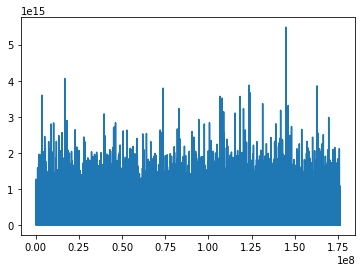

In [43]:
plt.plot(range(len(a[:,0])),a[:,0])